# Clasificador KNN para asignacion de segmentos

## Ejecutamos los imports necesarios para el analisis

In [58]:
from configparser import ConfigParser

from snowflake.connector import connect #type: ignore

from sklearn.model_selection import train_test_split #type: ignore
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, recall_score, precision_score 

from pandas import DataFrame, Series, merge

import json

from matplotlib import pyplot as plt

import numpy as np

from datetime import datetime

FECHA_INICIO = "'2023-08-21'"
FECHA_FIN = "'2023-08-27'"

## Ejecutamos el query para obtener los datos de los segmentos que estan actualmente en sessionM

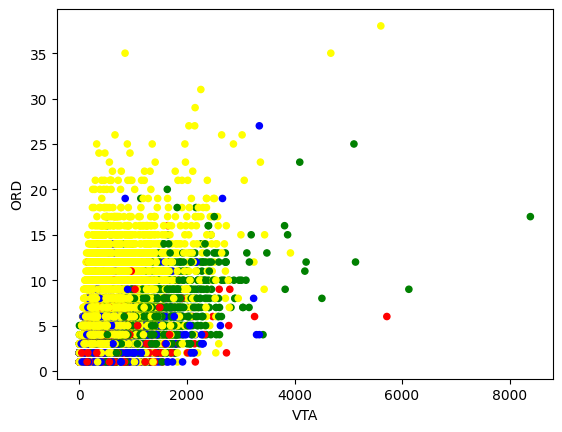

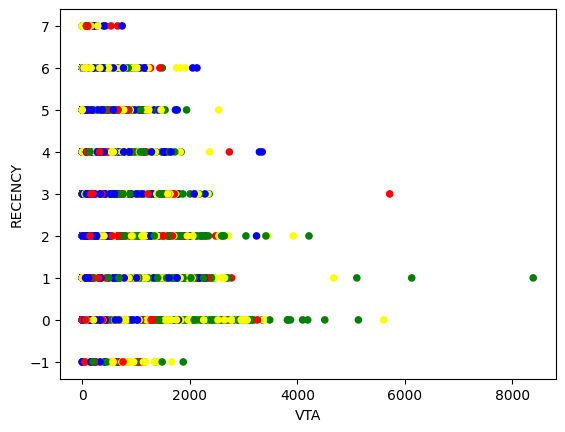

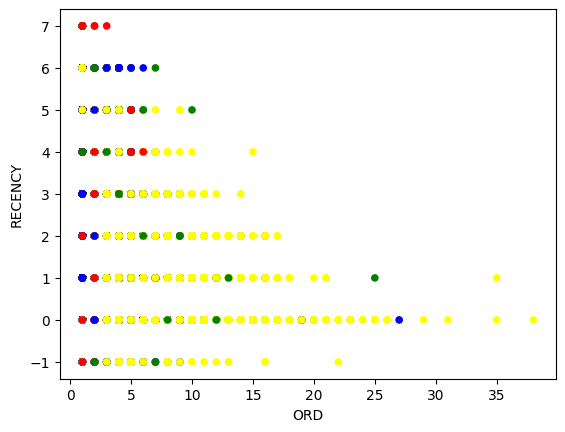

In [51]:
config = ConfigParser()
config.read('config.ini')

conn = connect(
    user = config.get('SNOWFLAKE', 'USER'),
    password = config.get('SNOWFLAKE', 'PASSWORD'),
    account = config.get('SNOWFLAKE', 'ACCOUNT'),
    database = config.get('SNOWFLAKE', 'DATABASE'),
    warehouse = config.get('SNOWFLAKE', 'WAREHOUSE'),
    schema = config.get('SNOWFLAKE', 'SCHEMA'),
    role = config.get('SNOWFLAKE', 'ROLE'),
)

cur = conn.cursor().execute(f"""
    WITH

    SEGMENTOS AS (
        SELECT
            SEGMENTO,
            EMAIL
        FROM
            SEGMENT_EVENTS.SESSIONM_SBX.SBX_SEGMENTOS_20230803
        INNER JOIN
            SEGMENT_EVENTS.SESSIONM_SBX.SM_USERS
        USING(
            USER_ID
        )
    )

    SELECT 
        SUM(CHECK_AMOUNT/1.16) AS VTA, 
        COUNT(DISTINCT TRANSACTION_ID) AS ORD,
        to_date({FECHA_FIN}) - to_date(max(CREATED_AT)) AS RECENCY,
        SEGMENTO
    FROM 
        SEGMENT_EVENTS.SESSIONM_SBX.FACT_TRANSACTIONS 
    INNER JOIN
        SEGMENTOS
    ON
        SEGMENTOS.EMAIL = FACT_TRANSACTIONS.EMAIL
    WHERE 
        TRANSACTION_DATE BETWEEN to_date({FECHA_INICIO}) AND to_date({FECHA_FIN})
    GROUP BY
        FACT_TRANSACTIONS.EMAIL,
        SEGMENTO
    ;
""")

df = cur.fetch_pandas_all() #type: ignore

colors = { 'LOW': 'red', 'MEDIUM': 'blue', 'HIGH': 'yellow', 'TOP': 'green'}

df.plot.scatter(x='VTA', y='ORD', c=df['SEGMENTO'].apply(lambda x: colors[x]))
df.plot.scatter(x='VTA', y='RECENCY', c=df['SEGMENTO'].apply(lambda x: colors[x]))
df.plot.scatter(x='ORD', y='RECENCY', c=df['SEGMENTO'].apply(lambda x: colors[x]))
plt.show()

LOW: rojo

MEDIUM: Azul

HIGH: Amarillo

TOP: Verde

## Ejecutamos el query para obtener los datos de los activos que actualmente no estan marcados en sessionM

In [52]:
cur_unlabeled = conn.cursor().execute(f"""
    WITH

    SEGMENTOS AS (
        SELECT
            SEGMENTO,
            EMAIL
        FROM
            SEGMENT_EVENTS.SESSIONM_SBX.SBX_SEGMENTOS_20230803
        INNER JOIN
            SEGMENT_EVENTS.SESSIONM_SBX.SM_USERS
        USING(
            USER_ID
        )
    )

    SELECT 
        FACT_TRANSACTIONS.EMAIL,
        SUM(CHECK_AMOUNT/1.16) AS VTA, 
        COUNT(DISTINCT TRANSACTION_ID) AS ORD,
        to_date({FECHA_FIN}) - to_date(max(CREATED_AT)) AS RECENCY
    FROM 
        SEGMENT_EVENTS.SESSIONM_SBX.FACT_TRANSACTIONS 
    LEFT JOIN
        SEGMENTOS
    ON
        SEGMENTOS.EMAIL = FACT_TRANSACTIONS.EMAIL
    WHERE 
        TRANSACTION_DATE BETWEEN to_date({FECHA_INICIO}) AND to_date({FECHA_FIN})
    AND
        SEGMENTOS.EMAIL IS null
    GROUP BY
        FACT_TRANSACTIONS.EMAIL,
        SEGMENTO
    ;
""")

df_unlabeled = cur_unlabeled.fetch_pandas_all() #type: ignore

In [53]:
clv_promocion = df['VTA'].mean()

clv_control = df_unlabeled['VTA'].mean()

lift = (clv_promocion / clv_control) - 1

print(f'CLV grupo promocion:{clv_promocion}')

print(f'CLV grupo control:{clv_control}')

print(f'Lift:{clv_control * 100}%')

246.25980066027438
228.7124339240873
0.07672239954392368


In [54]:
x_unlabeled = df_unlabeled.drop('EMAIL', axis = 1)

x:DataFrame = df.drop('SEGMENTO', axis = 1)
y = df['SEGMENTO']

scaler = StandardScaler()
x = scaler.fit_transform(x)
x_unlabeled = scaler.transform(x_unlabeled)

knn = KNeighborsClassifier(n_neighbors = 1)

knn.fit(x, y)

prediction = DataFrame(knn.predict(x_unlabeled))

df_unlabeled['SEGMENTO'] = prediction[0]

clv_promocion_por_segmento = df.groupby('SEGMENTO').agg({'VTA': 'mean'})

venta_promocion_por_segmento = df.groupby('SEGMENTO').agg({'VTA': 'sum'})

clv_control_por_segmento = df_unlabeled.groupby('SEGMENTO').agg({'VTA': 'mean'})

========== PROMOCION ==========
                 VTA
SEGMENTO            
HIGH      279.754792
LOW       174.127773
MEDIUM    197.939339
TOP       426.563446
                        VTA
SEGMENTO                   
HIGH      28925526.43104774
LOW        7410703.89655247
MEDIUM    17063558.68965473
TOP        8924133.85344862

========== CONTROL ==========
                 VTA
SEGMENTO            
HIGH      261.774909
LOW       173.921124
MEDIUM    187.331662
TOP       396.587943


In [55]:
venta_grupo_promocion = df['VTA'].sum()

print('venta grupo promocion:', venta_grupo_promocion)

venta_incremental = lift * int(venta_grupo_promocion)

print('venta incremental:', venta_incremental)

venta grupo promocion: 62323922.87070356
venta incremental: 4781640.844828335


In [65]:
merged = merge(clv_promocion_por_segmento, clv_control_por_segmento, on = 'SEGMENTO')

merged = merged.rename(columns = {'VTA_x' : 'CLV_PROMOCION', 'VTA_y' : 'CLV_CONTROL'})

merged['CLV_CONTROL'] = merged['CLV_CONTROL'].apply(lambda x : float(x))

merged['LIFT'] = (merged['CLV_PROMOCION'] - merged['CLV_CONTROL']) / merged['CLV_CONTROL']

merged = merge(merged, venta_promocion_por_segmento, on = 'SEGMENTO')

merged['VTA'] = merged['VTA'].apply(lambda x : float(x))

merged['VENTA_INCREMENTAL'] = merged['VTA'] * merged['LIFT']

venta_incremental_asignada = merged['VENTA_INCREMENTAL'].sum()
venta_incremental_por_asignar = venta_incremental - venta_incremental_asignada

merged['PORCENTAJE_VENTA_INCREMENTAL'] = merged['VENTA_INCREMENTAL'] / venta_incremental_asignada 

merged['VENTA_INCREMENTAL_TOTAL'] = merged['VENTA_INCREMENTAL'] + (venta_incremental_por_asignar * merged['PORCENTAJE_VENTA_INCREMENTAL'])

print(merged)